## Training

In [1]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense, Input, Add, merge, concatenate
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalAveragePooling3D, AveragePooling3D
from keras import metrics
from keras import optimizers
from keras.utils import plot_model
from keras import backend as K
from keras.utils.training_utils import multi_gpu_model
from keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.initializers import he_uniform
from keras.initializers import glorot_uniform

import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("models/")
sys.path.append("scripts/")

/usr/local/anaconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4, 5, 6, 7"

In [4]:
# Load the data
h5f = h5py.File('../CNN_experiments/data/data_nearest_neighbor.h5', 'r')
train_x, train_y = h5f['train_x'][:], h5f['train_y'][:]
valid_x, valid_y = h5f['valid_x'][:], h5f['valid_y'][:]
test_x, test_y = h5f['test_x'][:], h5f['test_y'][:]
h5f.close()

print(train_x.shape, valid_x.shape, test_x.shape)

(3012, 24, 24, 24, 16) (377, 24, 24, 24, 16) (376, 24, 24, 24, 16)


In [5]:
from models import Squeeze_model

In [6]:
# from IPython.display import SVG
# from keras.utils.vis_utils import plot_model, model_to_dot
# model_input = Input(shape=(24, 24, 24, 16))
# squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
# #plot_model(squeeze_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# SVG(model_to_dot(squeeze_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
# # plot_model(get_model4((24, 24, 24, 16)))

In [7]:
# Training parameters
nb_gpus = 4
nb_batch = nb_gpus*3
nb_epochs = 200
l_rate = 1e-4
decay_rate = l_rate / nb_epochs

In [8]:
# checkpoint
outputFolder = './weights'
# if not os.path.exists(outputFolder):
#     os.makedirs(outputFolder)

filepath=outputFolder+"/weights-rotated_random.h5"

#from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks_list = [ModelCheckpoint(filepath, 
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', period=1)]

In [9]:
model_input = Input(shape=(28, 28, 28, 16))
squeeze_model = Model(inputs=model_input, outputs=Squeeze_model(model_input))
model = multi_gpu_model(squeeze_model, gpus=nb_gpus)

model.compile(optimizer=optimizers.adam(lr=l_rate),# beta_1=0.99, beta_2=0.999),
              loss='mean_absolute_error')

In [10]:
from my_classes import AugmentedDataGeneratorRandom

In [11]:
rotation_count = 32
aug_data_gen = AugmentedDataGeneratorRandom(x=train_x, y=train_y, batch_size=nb_batch, rotation_count=rotation_count)
aug_val_gen = AugmentedDataGeneratorRandom(x=valid_x, y=valid_y, batch_size=nb_batch, rotation_count=rotation_count)

In [12]:
for x, y in aug_data_gen:
    print(x.shape, y.shape)
    break

(396, 28, 28, 28, 16) (396,)


In [13]:
history = model.fit_generator(generator=aug_data_gen, validation_data=aug_val_gen,
                              use_multiprocessing=False, 
                              epochs=nb_epochs, 
                              max_queue_size=10, 
                              workers=56, 
                              verbose=1, callbacks=callbacks_list)

Epoch 1/200
251/251 [==============================] - 427s 2s/step - loss: 1.8726 - val_loss: 1.7676

Epoch 00001: val_loss improved from inf to 1.76758, saving model to ./weights/weights-rotated_random.h5
Epoch 2/200
251/251 [==============================] - 407s 2s/step - loss: 1.5718 - val_loss: 1.2838

Epoch 00002: val_loss improved from 1.76758 to 1.28381, saving model to ./weights/weights-rotated_random.h5
Epoch 3/200
251/251 [==============================] - 386s 2s/step - loss: 1.5629 - val_loss: 1.3397

Epoch 00003: val_loss did not improve
Epoch 4/200
251/251 [==============================] - 382s 2s/step - loss: 1.5309 - val_loss: 1.3872

Epoch 00004: val_loss did not improve
Epoch 5/200
251/251 [==============================] - 383s 2s/step - loss: 1.5086 - val_loss: 1.5940

Epoch 00005: val_loss did not improve
Epoch 6/200
251/251 [==============================] - 376s 1s/step - loss: 1.5102 - val_loss: 1.4867

Epoch 00006: val_loss did not improve
Epoch 7/200
251/25

251/251 [==============================] - 378s 2s/step - loss: 1.2646 - val_loss: 1.3024

Epoch 00054: val_loss did not improve
Epoch 55/200
251/251 [==============================] - 374s 1s/step - loss: 1.2291 - val_loss: 1.2570

Epoch 00055: val_loss did not improve
Epoch 56/200
251/251 [==============================] - 378s 2s/step - loss: 1.2464 - val_loss: 1.2742

Epoch 00056: val_loss did not improve
Epoch 57/200
251/251 [==============================] - 370s 1s/step - loss: 1.2169 - val_loss: 1.1829

Epoch 00057: val_loss did not improve
Epoch 58/200
251/251 [==============================] - 378s 2s/step - loss: 1.2798 - val_loss: 1.2970

Epoch 00058: val_loss did not improve
Epoch 59/200
251/251 [==============================] - 380s 2s/step - loss: 1.2346 - val_loss: 1.2531

Epoch 00059: val_loss did not improve
Epoch 60/200
251/251 [==============================] - 374s 1s/step - loss: 1.2495 - val_loss: 1.1944

Epoch 00060: val_loss did not improve
Epoch 61/200
251/25

251/251 [==============================] - 381s 2s/step - loss: 1.1371 - val_loss: 1.2064

Epoch 00111: val_loss did not improve
Epoch 112/200
251/251 [==============================] - 378s 2s/step - loss: 1.1207 - val_loss: 1.2184

Epoch 00112: val_loss did not improve
Epoch 113/200
251/251 [==============================] - 378s 2s/step - loss: 1.1465 - val_loss: 1.2920

Epoch 00113: val_loss did not improve
Epoch 114/200
251/251 [==============================] - 380s 2s/step - loss: 1.1366 - val_loss: 1.2195

Epoch 00114: val_loss did not improve
Epoch 115/200
251/251 [==============================] - 381s 2s/step - loss: 1.1318 - val_loss: 1.1334

Epoch 00115: val_loss did not improve
Epoch 116/200
251/251 [==============================] - 381s 2s/step - loss: 1.1117 - val_loss: 1.2075

Epoch 00116: val_loss did not improve
Epoch 117/200
251/251 [==============================] - 379s 2s/step - loss: 1.1055 - val_loss: 1.1215

Epoch 00117: val_loss did not improve
Epoch 118/200

251/251 [==============================] - 379s 2s/step - loss: 0.9981 - val_loss: 1.1325

Epoch 00168: val_loss did not improve
Epoch 169/200
251/251 [==============================] - 375s 1s/step - loss: 0.9699 - val_loss: 1.2811

Epoch 00169: val_loss did not improve
Epoch 170/200
251/251 [==============================] - 375s 1s/step - loss: 0.9285 - val_loss: 1.1646

Epoch 00170: val_loss did not improve
Epoch 171/200
251/251 [==============================] - 379s 2s/step - loss: 0.9391 - val_loss: 1.2175

Epoch 00171: val_loss did not improve
Epoch 172/200
251/251 [==============================] - 377s 2s/step - loss: 0.9765 - val_loss: 1.3246

Epoch 00172: val_loss did not improve
Epoch 173/200
251/251 [==============================] - 382s 2s/step - loss: 0.9731 - val_loss: 1.1245

Epoch 00173: val_loss did not improve
Epoch 174/200
251/251 [==============================] - 381s 2s/step - loss: 0.9703 - val_loss: 1.1854

Epoch 00174: val_loss did not improve
Epoch 175/200

In [14]:
# Save the history
import pickle

with open(os.path.join(outputFolder, "history_rotated-random.pickle"), 'wb') as f:
    pickle.dump(history.history, f)

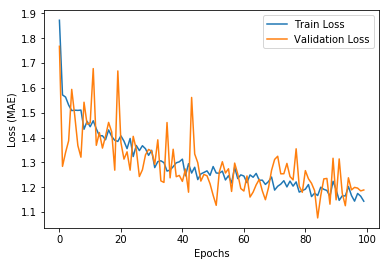

In [16]:

plt.figure()
plt.plot(history.history['loss'][:100])
plt.plot(history.history['val_loss'][:100])
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.legend(['Train Loss', 'Validation Loss'])
plt.savefig('nn-rotated-random.png', format='png', dpi=1000)
plt.show()

In [15]:
# Save the weights
model.load_weights(filepath)

In [16]:
from sklearn.metrics import r2_score

In [17]:
rotation_count = 32
sample_size = 200

In [18]:
train_aug_data_gen = AugmentedDataGeneratorRandom(x=train_x[:sample_size],
                                            y=train_y[:sample_size],
                                            batch_size=sample_size,
                                            rotation_count=rotation_count)

test_aug_data_gen = AugmentedDataGeneratorRandom(x=test_x[:sample_size],
                                            y=test_y[:sample_size],
                                            batch_size=sample_size,
                                            rotation_count=rotation_count)

In [19]:
# Train r2

for x, y in train_aug_data_gen:
    # Without average
    train_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Train r2 (without average): ", train_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*(rotation_count+1)
        end = i*(rotation_count+1) + (rotation_count+1)
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    train_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Train r2 (with average): ", train_r2)
    break

Train r2 (without average):  0.548314890048
Train r2 (with average):  0.588999834566


In [20]:
# Test r2

for x, y in test_aug_data_gen:
    # Without average
    test_r2 = r2_score(y_true=y, y_pred=model.predict(x))
    print("Test r2 (without average): ", test_r2)
    
    # With average
    y_pred = model.predict(x)[:, 0]
    
    sample_y = np.zeros(sample_size)
    sample_ypred = np.zeros(sample_size)
    for i in range(sample_size):
        start = i*(rotation_count+1)
        end = i*(rotation_count+1) + (rotation_count+1)
        mean_ypred = np.mean(y_pred[start:end])
        mean_y = np.mean(y[start:end])
        sample_ypred[i] = mean_ypred
        sample_y[i] = mean_y
    
    test_r2 = r2_score(y_true=sample_y, y_pred=sample_ypred)
    print("Test r2 (with average): ", test_r2)
    break

Test r2 (without average):  0.403869662474
Test r2 (with average):  0.432231462409
